In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Intro to Study

In this noteboook we will develop a model to predict whether a cancer cell is benign (B) or malignant (M). Our data consists of 569 samples, each of which having 33 initial features. The data was sourced from Kaggle at the following url: https://www.kaggle.com/datasets/erdemtaha/cancer-data and downloaded into a local repository.


In [3]:
# Read in data and visually inspect

df = pd.read_csv('Cancer_Data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Data Preprocessing

In this section, we will remove unneeded columns from the dataset, scale all numerical columns, and split the data into training and testing sets.

In [4]:
# Note that final column is unused, therefore it can be dropped

df.drop('Unnamed: 32', axis=1, inplace=True)

In [5]:
# Separate data into predictor and response variables. Dropping `id` column as we will assume it 
# is entirely independent of the diagnosis.

x_raw = df.drop(['diagnosis', 'id'], axis=1)
y_raw = df['diagnosis']

In [6]:
# Replace `diagnosis` with binary response value ('B' -> 0, 'M' -> 1).
# Scale all predictor variables and separate data into train and test sets (80/20 split)

y_scaled = np.array(y_raw.replace(['B', 'M'], [0, 1]))

x_scaler = MinMaxScaler()
x_scaler.fit(x_raw)

x_scaled = x_scaler.transform(x_raw)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=.2)

In [7]:
# Assess issue of class imbalance - since proportion is relatively close to a 50/50 split we 
# will not use resampling techniques.

print('Proportion of Malignant tumor labels in train data set: %.3f' % (sum(y_train)/y_train.size))

Proportion of Malignant tumor labels in train data set: 0.378


## Model Creation/Results

In this section, we will train a naive logistic regression model with no tuning (l2 penalty applied with a regularization strength `c=1.0`, further documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Then, we will print the model's accuracy, precision, and recall on both the training and testing datasets.

In [8]:
# Create and train a basic logistic regression model on the training dataset

basic_model = LogisticRegression()
basic_model.fit(x_train, y_train)

LogisticRegression()

In [9]:
# Define function to print model results

def print_model_results(estimator):
    print("Basic model accuracy on training data:", accuracy_score(y_train, estimator.predict(x_train)))
    print("Basic model precision on training data:", precision_score(y_train, estimator.predict(x_train)))
    print("Basic model recall on training data:", recall_score(y_train, estimator.predict(x_train)), '\n')

    print("Basic model accuracy on test data:", accuracy_score(y_test, estimator.predict(x_test)))
    print("Basic model precision on test data:", precision_score(y_test, estimator.predict(x_test)))
    print("Basic model recall on test data:", recall_score(y_test, estimator.predict(x_test)))

In [10]:
# Print results for basic model

print_model_results(basic_model)

Basic model accuracy on training data: 0.9692307692307692
Basic model precision on training data: 0.9876543209876543
Basic model recall on training data: 0.9302325581395349 

Basic model accuracy on test data: 0.956140350877193
Basic model precision on test data: 0.972972972972973
Basic model recall on test data: 0.9


## Fine-Tuning

Now, we will fine tune our choice of penalization parameter through cross-validation, creating a more generalized model with optimal hyperparameters tuned to maximize model accuracy. 

In [11]:
# Define logspace of 50 (default) penalization parameter values ranging from 1e-3 to 1e3.
# Create GridSearch using default 5-fold cross-validation and fit it to training data.

reg_strengths = dict(C = np.logspace(-3, 3, 50))
test_model = LogisticRegression(max_iter=300) # triple default number of max iter to better guarantee convergence

clf = GridSearchCV(test_model, reg_strengths) # default 5 fold CV
clf.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=300),
             param_grid={'C': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1...
       8.68511374e-01, 1.15139540e+00, 1.52641797e+00, 2.02358965e+00,
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03])})

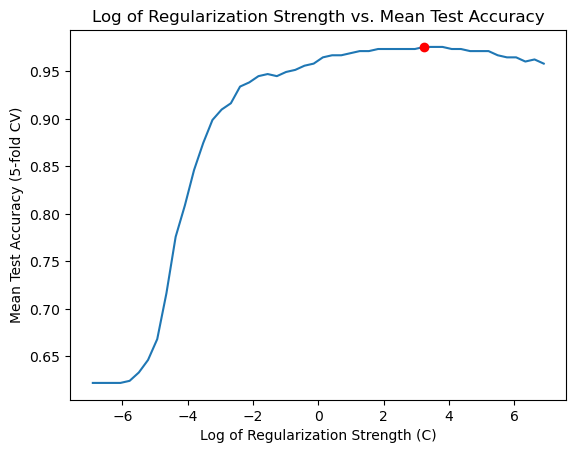

In [12]:
# Extract mean test scores on training data and plot them for the log of each value of penalization parameter.
# Highlight the highest performing mean test score in red.

mean_test_scores = clf.cv_results_['mean_test_score']
coefficients = np.array(clf.cv_results_['param_C'], dtype='float')

plt.plot(np.log(coefficients), mean_test_scores)
plt.plot(np.log(clf.best_estimator_.C), mean_test_scores[np.where(coefficients==clf.best_estimator_.C)[0]], 'ro')
plt.title('Log of Regularization Strength vs. Mean Test Accuracy')
plt.xlabel('Log of Regularization Strength (C)')
plt.ylabel('Mean Test Accuracy (5-fold CV)')
plt.show()

In [13]:
# Extract highest performing model and print model results

tuned_model = clf.best_estimator_

print_model_results(tuned_model)

Basic model accuracy on training data: 0.9824175824175824
Basic model precision on training data: 0.9880952380952381
Basic model recall on training data: 0.9651162790697675 

Basic model accuracy on test data: 0.9912280701754386
Basic model precision on test data: 1.0
Basic model recall on test data: 0.975


## Model Selection

In this section, we will try additional types of classification models to improve our model's accuracy.

In [14]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [15]:
#
# Returns an array of the highest performing models, a single model for each model type

def grid_search_models():
    

SyntaxError: incomplete input (1846473887.py, line 5)

In [16]:
hyper_params = {'learning rate': np.logspace(-3, 3, 20)
               }

In [17]:
hyper_params

{'learning rate': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
        1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
        3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
        6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
        1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])}